# Estimating Aqueous Solubility from Molecular structure

In [1]:
#https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt
import pandas as pd
df=pd.read_csv('D:\\ESOL\\Delaney.csv', encoding='latin1')
df.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [2]:
df.SMILES

0                                    ClCC(Cl)(Cl)Cl
1                                      CC(Cl)(Cl)Cl
2                                    ClC(Cl)C(Cl)Cl
3                                        ClCC(Cl)Cl
4                               FC(F)(Cl)C(F)(Cl)Cl
                           ...                     
1139                   CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140          CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141         CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O 
1142    Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O
1143                         CNC(=O)Oc1cc(C)cc(C)c1
Name: SMILES, Length: 1144, dtype: object

In [3]:
from rdkit import Chem

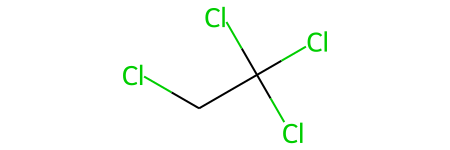

In [4]:
Chem.MolFromSmiles(df.SMILES[0])

In [5]:
#convert the SMILES string to rdkit object
mol_list= []
for element in df.SMILES:
  mol = Chem.MolFromSmiles(element)
  mol_list.append(mol)

#len(mol_list)

## Molecular Descriptors
###### cLogP- Octanol-water partition coefficient
###### MW- Molecular weight
###### RB- Number of rotatable bonds
###### AP- Aromatic proportion = number of aromatic atoms / number of heavy atoms
## ---------------------------------------------------------------------------


#### Getting LogP, MW and RB

In [6]:


import numpy as np
from rdkit.Chem import Descriptors
def generate(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)
           
        row = np.array([desc_MolLogP,
                        desc_MolWt,
                        desc_NumRotatableBonds])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MolLogP","MolWt","NumRotatableBonds"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

df2 = generate(df.SMILES)
#df2

#### Getting AP (number of aromatic atoms / number of heavy atoms)

In [7]:
def AromaticAtoms(m):
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  aa_count = []
  for i in aromatic_atoms:
    if i==True:
      aa_count.append(1)
  sum_aa_count = sum(aa_count)
  return sum_aa_count

desc_AromaticAtoms = [AromaticAtoms(element) for element in mol_list]
#desc_AromaticAtoms

In [8]:
# Heavy atoms
desc_HeavyAtomCount = [Descriptors.HeavyAtomCount(element) for element in mol_list]
#desc_HeavyAtomCount

In [9]:
#Finally computing AP= AA/HA
desc_AromaticProportion = [AromaticAtoms(element)/Descriptors.HeavyAtomCount(element) for element in mol_list]
desc_AromaticProportion

from pandas import DataFrame
df_desc_AromaticProportion = DataFrame(desc_AromaticProportion,columns=['AromaticProportion'])
#df_desc_AromaticProportion

## Making Dataset

#### Combine all computed descriptors from 2 dataframes(df2 and df_desc_AromaticProportion) into 1 dataframe.

In [10]:
#X matrix
X = pd.concat([df2,df_desc_AromaticProportion], axis=1)
X

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion
0,2.59540,167.850,0.0,0.000000
1,2.37650,133.405,0.0,0.000000
2,2.59380,167.850,1.0,0.000000
3,2.02890,133.405,1.0,0.000000
4,2.91890,187.375,1.0,0.000000
...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000
1140,3.42130,286.114,2.0,0.333333
1141,3.60960,308.333,4.0,0.695652
1142,2.56214,354.815,3.0,0.521739


<AxesSubplot:>

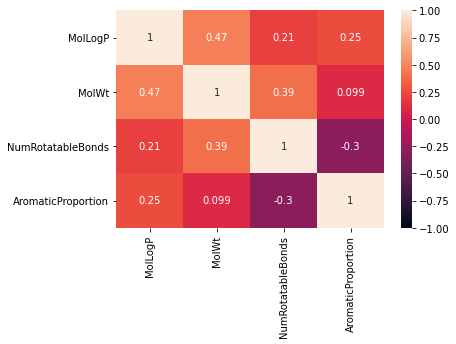

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

Var_Corr = X.corr()
# plot correlation heatmap
sns.heatmap(Var_Corr, vmin=-1, vmax=1, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)

In [12]:
#Y matrix- the value we predict, logS
Y = df.iloc[:,1]
Y

0      -2.180
1      -2.000
2      -1.740
3      -1.480
4      -3.040
        ...  
1139    1.144
1140   -4.925
1141   -3.893
1142   -3.790
1143   -2.581
Name: measured log(solubility:mol/L), Length: 1144, dtype: float64

Text(0.5, 0, 'AromaticProportion')

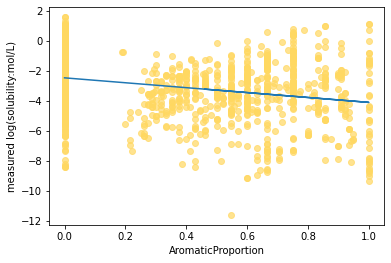

In [13]:
x_list_of_molwt = np.array(X['AromaticProportion'].to_list())
y_list_of_Y = np.array(Y.to_list())
m, b = np.polyfit( x_list_of_molwt,y_list_of_Y, 1)
plt.plot(x_list_of_molwt,y_list_of_Y, 'o', c="#ffd861", alpha=0.7)
plt.plot(x_list_of_molwt, m*x_list_of_molwt + b)
plt.ylabel('measured log(solubility:mol/L)')
plt.xlabel('AromaticProportion')

## Splitting Data

#### 80%-> training data
#### 20% -> testing data

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2)

## 1. Linear Regression

In [14]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
lin_model = linear_model.LinearRegression()
lin_model.fit(X_train, Y_train)

LinearRegression()

In [15]:
#Results
Y_pred_train = lin_model.predict(X_train)


print('Coefficients:', lin_model.coef_)
print('Intercept:', lin_model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Coefficients: [-0.76774926 -0.00640718  0.01230929 -0.38766774]
Intercept: 0.23509695340101588
Mean squared error (MSE): 0.98
Coefficient of determination (R^2): 0.77


In [23]:
# Predict the LogS value of X_test 
Y_pred_test = lin_model.predict(X_test)

print('Coefficients:', lin_model.coef_)
print('Intercept:', lin_model.intercept_)
print('Mean squared error (MSE): %.2f'
      % (mean_squared_error(Y_test, Y_pred_test)))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

Coefficients: [-0.76774926 -0.00640718  0.01230929 -0.38766774]
Intercept: 0.23509695340101588
Mean squared error (MSE): 1.13
Coefficient of determination (R^2): 0.75


In [24]:
# Lin Regression eqn using training set

yintercept = '%.2f' % lin_model.intercept_
LogP = '%.2f LogP' % lin_model.coef_[0]
MW = '%.4f MW' % lin_model.coef_[1]
RB = '%.4f RB' % lin_model.coef_[2]
AP = '%.2f AP' % lin_model.coef_[3]
print('LogS= ' + 
      ' ' + 
      yintercept + 
      ' ' + 
      LogP + 
      ' ' + 
      MW + 
      ' ' + 
      RB + 
      ' ' + 
      AP)

LogS=  0.24 -0.77 LogP -0.0064 MW 0.0123 RB -0.39 AP


In [25]:
Y_train.shape, Y_pred_train.shape
Y_test.shape, Y_pred_test.shape

((229,), (229,))

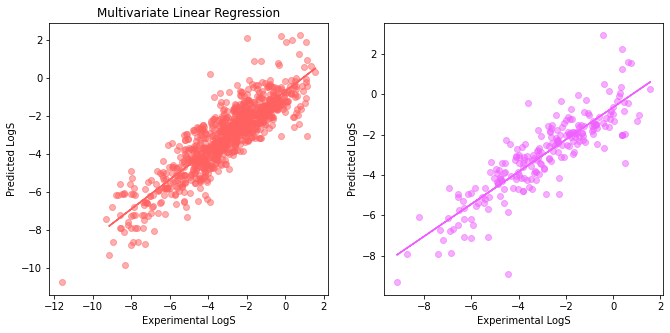

In [77]:
import matplotlib.pyplot as plt
plt.figure(figsize=(11,5))

# 1 row, 2 column, plot 1
plt.subplot(1, 2, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#FF6161", alpha=0.5)

z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#FF6161")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')
plt.title("Multivariate Linear Regression")

# 1 row, 2 column, plot 2
plt.subplot(1, 2, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#EF61FF", alpha=0.5)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#EF61FF")

plt.xlabel('Experimental LogS')
plt.ylabel('Predicted LogS')
plt.savefig('plot_horizontal_logS.png')
plt.savefig('plot_horizontal_logS.pdf')
plt.show()

## 2. Ridge Regression

In [103]:
from sklearn import linear_model
Ridgemodel=linear_model.Ridge(alpha=0.99)
Ridgemodel.fit(X_train, Y_train)
Y_ridge_test = Ridgemodel.predict(X_test)

In [104]:
print('Coefficients:', Ridgemodel.coef_)
print('Intercept:', Ridgemodel.intercept_)
print('Mean squared error (MSE): %.2f'
      % (mean_squared_error(Y_test, Y_ridge_test)))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_ridge_test))

Coefficients: [-0.76763047 -0.00641148  0.01250319 -0.38375703]
Intercept: 0.23381453585510448
Mean squared error (MSE): 1.13
Coefficient of determination (R^2): 0.75


In [88]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
# define search
search = GridSearchCV(Ridgemodel, grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, Y_train)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -0.999
Config: {'alpha': 0.99}


In [81]:
yintercept = '%.2f' % Ridgemodel.intercept_
LogP = '%.2f LogP' % Ridgemodel.coef_[0]
MW = '%.4f MW' % Ridgemodel.coef_[1]
RB = '%.4f RB' % Ridgemodel.coef_[2]
AP = '%.2f AP' % Ridgemodel.coef_[3]
print('LogS= ' + 
      ' ' + 
      yintercept + 
      ' ' + 
      LogP + 
      ' ' + 
      MW + 
      ' ' + 
      RB + 
      ' ' + 
      AP)

LogS=  0.23 -0.77 LogP -0.0064 MW 0.0124 RB -0.39 AP


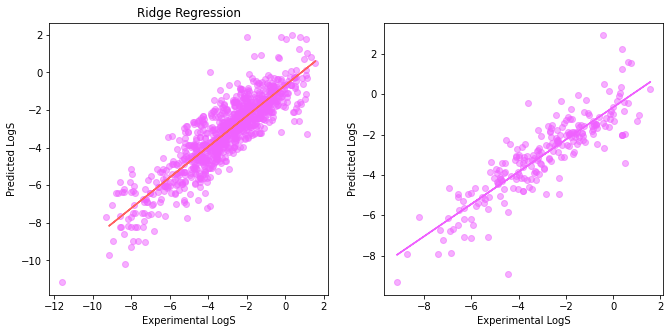

In [82]:
import matplotlib.pyplot as plt
plt.figure(figsize=(11,5))

# 1 row, 2 column, plot 1
plt.subplot(1, 2, 1)
plt.scatter(x=Y_train, y=Y_ridge_train, c="#EF61FF", alpha=0.5)

z = np.polyfit(Y_train, Y_ridge_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#FF6161")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')
plt.title("Ridge Regression")

# 1 row, 2 column, plot 2
plt.subplot(1, 2, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#EF61FF", alpha=0.5)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#EF61FF")

plt.xlabel('Experimental LogS')
plt.ylabel('Predicted LogS')
plt.savefig('plot_horizontal_logS.png')
plt.savefig('plot_horizontal_logS.pdf')
plt.show()

In [128]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import AdaBoostRegressor

# define the model
model = AdaBoostRegressor()
# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, Y_train, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: 0.818 (0.029)


In [130]:
model.fit(X_train, Y_train)
prediction=model.predict(X_test)
print(f"r2 Score Of Test Set : {r2_score(Y_test, prediction)}")

r2 Score Of Test Set : 0.7908155723964897


In [132]:
print('Mean squared error (MSE): %.2f'
      % (mean_squared_error(Y_test, prediction)))

Mean squared error (MSE): 0.95


In [134]:
Y_pred_train = model.predict(X_train)

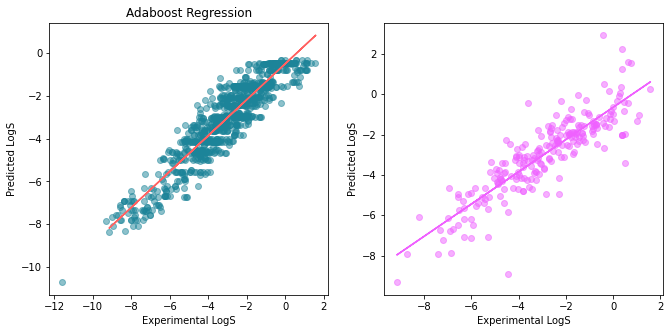

In [136]:
import matplotlib.pyplot as plt
plt.figure(figsize=(11,5))

# 1 row, 2 column, plot 1
plt.subplot(1, 2, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#1c8499", alpha=0.5)

z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#FF6161")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')
plt.title("Adaboost Regression")

# 1 row, 2 column, plot 2
plt.subplot(1, 2, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#EF61FF", alpha=0.5)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#EF61FF")

plt.xlabel('Experimental LogS')
plt.ylabel('Predicted LogS')
plt.savefig('plot_horizontal_logS.png')
plt.savefig('plot_horizontal_logS.pdf')
plt.show()